In [1]:
import os
import matplotlib
import pandas as pd
import seaborn as sns

from pandarallel import pandarallel
from IPython.display import display

In [2]:
pandarallel.initialize(progress_bar=True, nb_workers=8)
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [35]:
df = pd.read_csv(os.path.join("predict-closed-questions-on-stack-overflow", "train.csv"), index_col="PostId")

In [4]:
df = df.sample(10_000)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 9749029 to 4746669
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   PostCreationDate                     10000 non-null  object
 1   OwnerUserId                          10000 non-null  int64 
 2   OwnerCreationDate                    10000 non-null  object
 3   ReputationAtPostCreation             10000 non-null  int64 
 4   OwnerUndeletedAnswerCountAtPostTime  10000 non-null  int64 
 5   Title                                10000 non-null  object
 6   BodyMarkdown                         10000 non-null  object
 7   Tag1                                 9999 non-null   object
 8   Tag2                                 8390 non-null   object
 9   Tag3                                 5862 non-null   object
 10  Tag4                                 3093 non-null   object
 11  Tag5                             

In [6]:
df.head()

,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
PostId,,,,,,,,,,,,,,
9749029,03/17/2012 10:00:22,1041320,11/11/2011 08:26:38,28,1,How to run or compile DirectX 10 application i...,"Please, help.\r\nDoes anyone know how to compi...",windows-xp,directx-10,NaN,NaN,NaN,NaN,open
6987679,08/08/2011 19:46:57,294863,03/16/2010 15:11:55,2925,176,Nested Transactions in .NET,How can I perform the equivalent of this? [My ...,.net,.net-4.0,transactions,sql-server-2008-r2,NaN,NaN,open
5219884,03/07/2011 12:46:11,65731,02/12/2009 20:02:41,117,2,Query Error: where is the error?,I am getting the following error:\r\n\r\n [...,php,mysql,NaN,NaN,NaN,NaN,open
3562965,08/25/2010 05:00:41,412565,08/06/2010 01:28:16,3,0,Can't specify static methods as part of an Int...,I have a set of objects that I want to conform...,c#,.net,NaN,NaN,NaN,NaN,open
10718173,05/23/2012 10:33:10,837956,07/10/2011 21:33:14,3,0,Get country name and country code in android?,I am trying to get country name and country co...,android,NaN,NaN,NaN,NaN,NaN,open


In [7]:
df["PostCreationDate"] = pd.to_datetime(df["PostCreationDate"])
df["OwnerCreationDate"] = pd.to_datetime(df["OwnerCreationDate"])

In [8]:
df.drop(columns=["PostClosedDate", "OwnerUserId"], inplace=True)

In [9]:
df["TimeDiffSinceRegistration"] = df["PostCreationDate"] - df["OwnerCreationDate"]

In [10]:
df.drop(columns=["PostCreationDate", "OwnerCreationDate"], inplace=True)

In [36]:
df["Closed"] = df["OpenStatus"] != "open"

In [12]:
df["NumTags"] = df[["Tag1", "Tag2", "Tag3", "Tag4", "Tag5"]].notnull().sum(axis=1)

In [16]:
df["TitleLength"] = df["Title"].str.len()
df["BodyMarkdownLength"] = df["BodyMarkdown"].str.len()

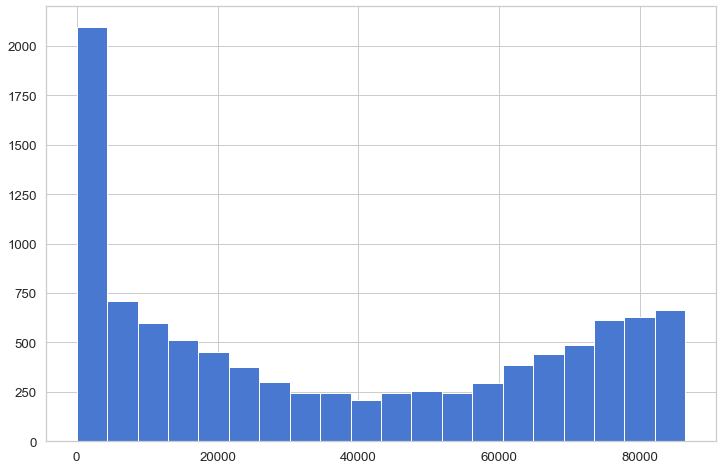

In [17]:
df["TimeDiffSinceRegistration"].dt.seconds.hist(bins=20);

<AxesSubplot:>

False    0.9804
True     0.0196
Name: Closed, dtype: float64

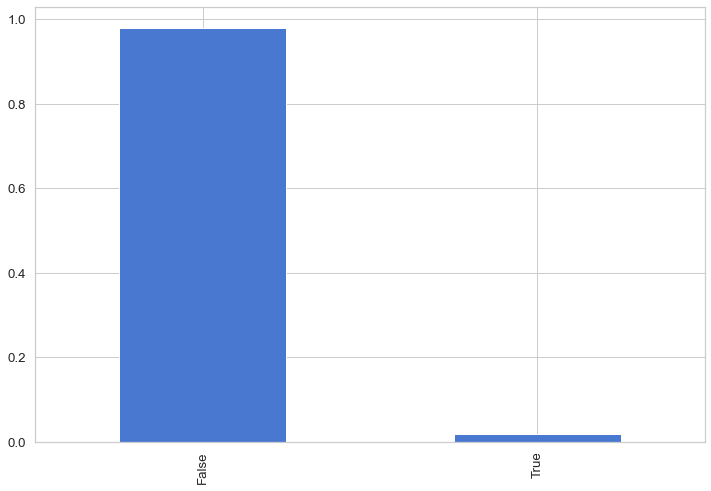

In [18]:
counts = df["Closed"].value_counts(normalize=True)
display(counts.plot.bar())
counts

<AxesSubplot:>

open                   0.9804
not a real question    0.0095
not constructive       0.0047
off topic              0.0040
too localized          0.0014
Name: OpenStatus, dtype: float64

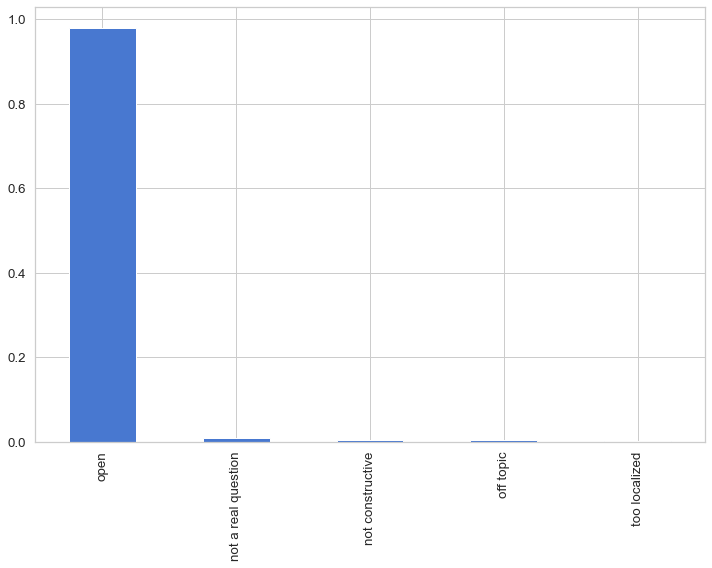

In [19]:
counts = df["OpenStatus"].value_counts(normalize=True)
display(counts.plot.bar())
counts

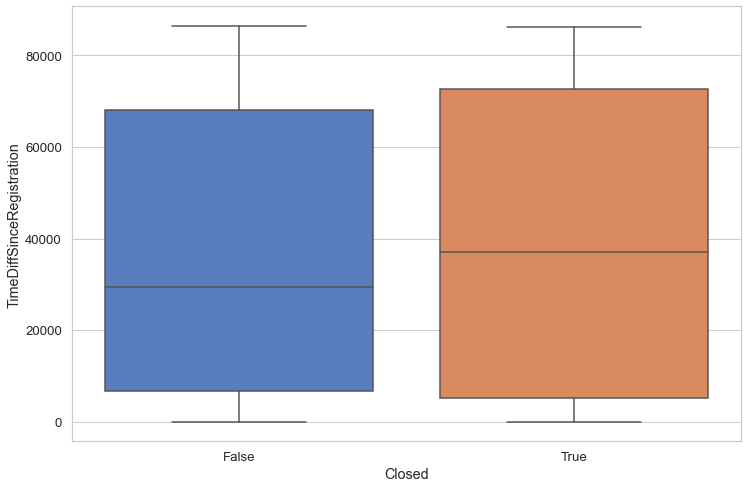

In [20]:
sns.boxplot(data=df, x="Closed", y=df["TimeDiffSinceRegistration"].dt.seconds);

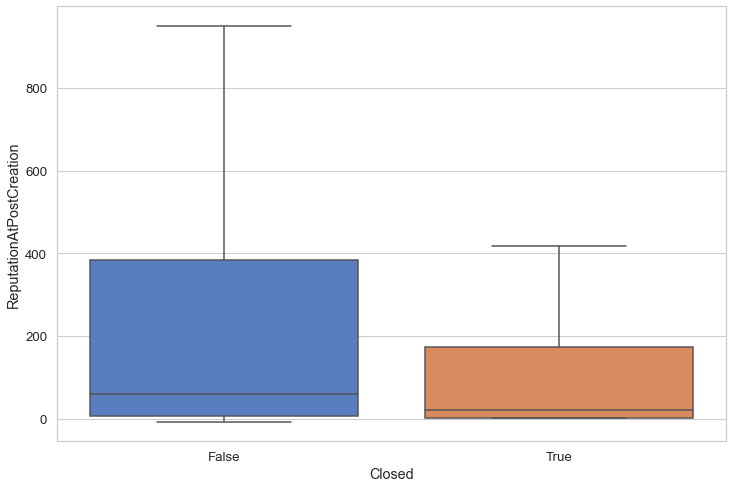

In [21]:
sns.boxplot(data=df, x="Closed", y="ReputationAtPostCreation", showfliers=False);

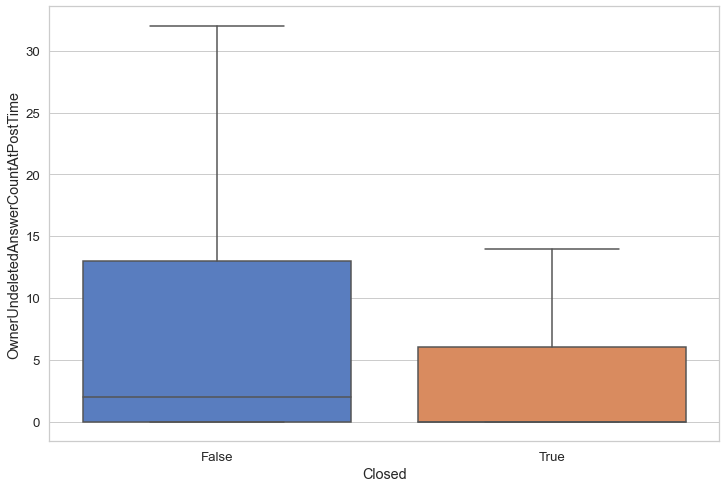

In [22]:
sns.boxplot(data=df, x="Closed", y="OwnerUndeletedAnswerCountAtPostTime", showfliers=False);

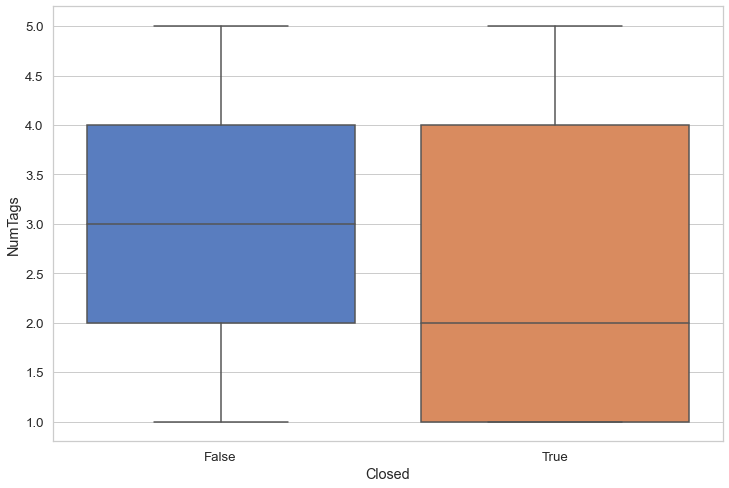

In [23]:
sns.boxplot(data=df, x="Closed", y="NumTags");

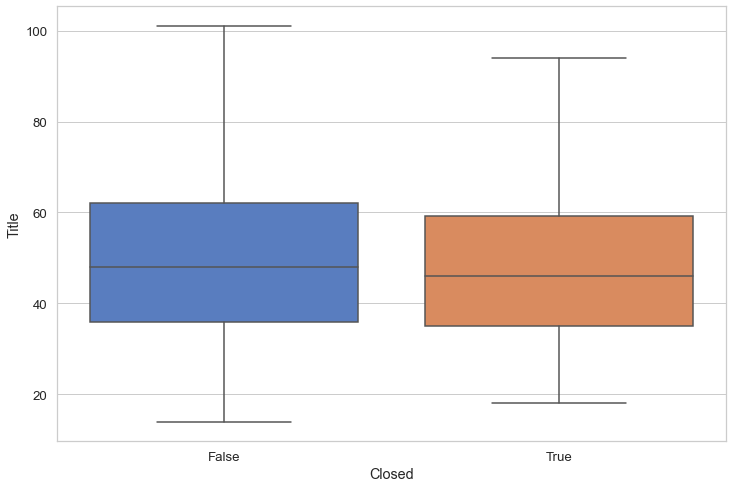

In [24]:
sns.boxplot(data=df, x="Closed", y=df["Title"].str.len(), showfliers=False);

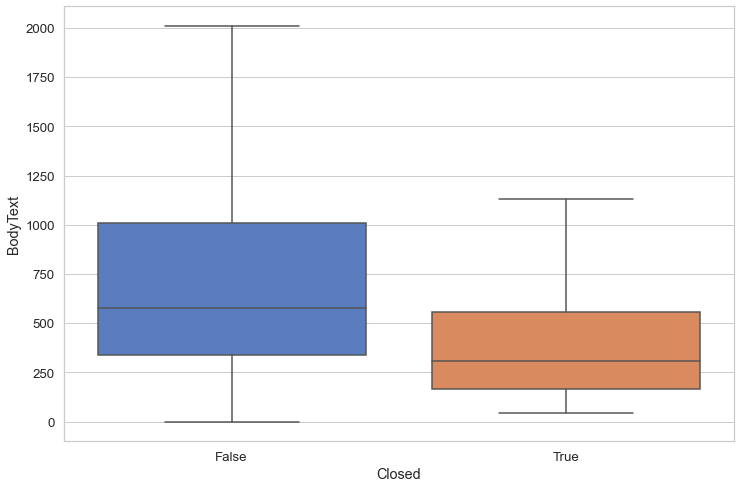

In [25]:
sns.boxplot(data=df, x="Closed", y=df["BodyMarkdownLength"], showfliers=False);

In [26]:
from transformers import BertTokenizer

In [27]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [28]:
token_lens = []

for txt in df["BodyMarkdown"]:
    tokens = tokenizer.encode(txt, max_length=1000)
    token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/Users/rubens/.local/share/virtualenvs/bert-kaggle-stackoverflow-a4Em9Yy8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

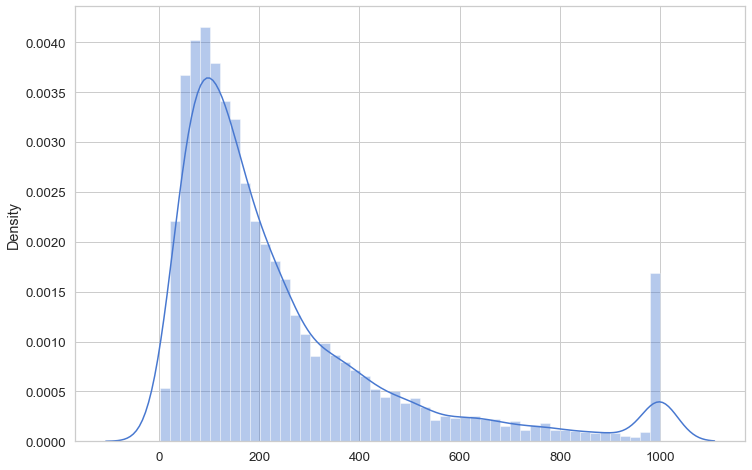

In [29]:
sns.distplot(token_lens)